<a href="https://colab.research.google.com/github/Aman-Agrawal01/Kaggle-Notebooks/blob/master/Skin%20Cancer%3A%20Malignant%20vs.%20Benign/Skin_Cancer_Malignant_vs_Benign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
! pip install -q kaggle

from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

Saving kaggle.json to kaggle.json
 99% 322M/325M [00:05<00:00, 96.9MB/s]
100% 325M/325M [00:05<00:00, 63.6MB/s]


In [ ]:
from zipfile import ZipFile  
file_name = '/content/skin-cancer-malignant-vs-benign.zip'        
with ZipFile(file_name,'r') as zip:
  zip.extractall()

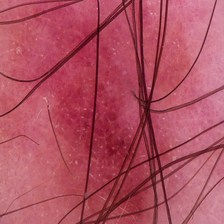

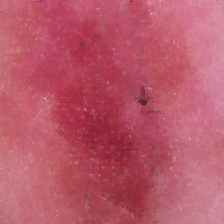

In [ ]:
def preprocessing(src):
  # Convert the original image to grayscale
  src = np.array(src)
  src = src.astype('uint8')
  grayScale = cv2.cvtColor( src, cv2.COLOR_RGB2GRAY )
  # Kernel for the morphological filtering
  kernel = cv2.getStructuringElement(1,(17,17))
  # Perform the blackHat filtering on the grayscale image to find the 
  # hair countours
  blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
  # intensify the hair countours in preparation for the inpainting 
  # algorithm
  ret,thresh2 = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
  # inpaint the original image depending on the mask
  dst = cv2.inpaint(src,thresh2,1,cv2.INPAINT_TELEA)
  dst = dst.astype('float32')
  return dst
cv2_imshow(cv2.imread('/content/train/benign/13.jpg'))
cv2_imshow(preprocessing(cv2.imread('/content/train/benign/13.jpg')))

In [ ]:
TRAINING_DIR = '/content/train'
TESTING_DIR = '/content/test'

datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=preprocessing)

train_generator = datagen.flow_from_directory(TRAINING_DIR,
                                              class_mode='binary',
                                              target_size=(224,224),
                                              color_mode='rgb',
                                              batch_size=50)
test_generator = datagen.flow_from_directory(TESTING_DIR,
                                              class_mode='binary',
                                              target_size=(224,224),
                                              color_mode='rgb',
                                              batch_size=50)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception = InceptionV3(include_top=False,weights='imagenet',input_shape=(224,224,3))

for layer in inception.layers:
    layer.trainable=False

model = tf.keras.Sequential([
              inception,
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(1,activation='sigmoid')
])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51201     
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
history = model.fit_generator(train_generator,epochs=5,validation_data=test_generator,callbacks=[callbacks])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
53/53 [==============================] - 394s 7s/step - loss: 1.0913 - accuracy: 0.7520 - val_loss: 0.5793 - val_accuracy: 0.7818
Epoch 2/5
53/53 [==============================] - 394s 7s/step - loss: 0.3505 - accuracy: 0.8544 - val_loss: 0.4826 - val_accuracy: 0.8076
Epoch 3/5
53/53 [==============================] - 390s 7s/step - loss: 0.2145 - accuracy: 0.9075 - val_loss: 0.4408 - val_accuracy: 0.8167
Epoch 4/5
53/53 [==============================] - 393s 7s/step - loss: 0.1183 - accuracy: 0.9583 - val_loss: 0.3755 - val_accuracy: 0.8470
Epoch 5/5
53/53 [==============================] - 393s 7s/step - loss: 0.0960 - accuracy: 0.9636 - val_loss: 0.4502 - val_accuracy: 0.8303
